In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from scipy import spatial

In [4]:
# Stopwords in french (no information)
stopwords_fr = []
with open("data/stopwords/stopwords-fr.txt", 'r', encoding='utf-8') as f:
    stopwords_fr = f.readlines()
    stopwords_fr = [w.strip() for w in stopwords_fr]
stopwords_fr[:10]

['a', 'à', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies']

In [5]:
stopwords_fr.remove('o|')

In [6]:
# punctations in french (no information)
punctuations_fr = "\"$%&'?!()*+,-./:;=@[\]^_`{|}'~«»´’–"

In [7]:
# Load all the tweets
party_tweets = pd.read_csv("data/twitter_data/party_tweets.csv")
member_tweets = pd.read_csv("data/twitter_data/merged_member_tweets.csv")

In [8]:
# Adding a new column called year and which contains the year of the tweets
def extract_year(tweets):
    tweets_copy = tweets.copy()
    tweets_copy['year'] = tweets_copy['timestamp'].str[-4:].astype(int)  
    return tweets_copy

In [9]:
# Add the years of the tweets
party_tweets = extract_year(party_tweets)
member_tweets = extract_year(member_tweets)

In [10]:
# Change name of a column to be coherent
party_tweets = party_tweets.rename(columns={'partyname': 'party_name'})

In [11]:
party_tweets.head()

id                       timestamp  party_name username  \
0  1196812925580840961  Tue Nov 19 15:30:11 +0000 2019  UDC Suisse    UDCch   
1  1196375024124538880  Mon Nov 18 10:30:07 +0000 2019  UDC Suisse    UDCch   
2  1189851774510874624  Thu Oct 31 10:29:04 +0000 2019  UDC Suisse    UDCch   
3  1187013387508748288  Wed Oct 23 14:30:19 +0000 2019  UDC Suisse    UDCch   
4  1186266665358647298  Mon Oct 21 13:03:07 +0000 2019  UDC Suisse    UDCch   

                                          tweet_text all_hashtags  \
0  Durant la session d’hiver à venir, le Parlemen...           []   
1  Le glissement à gauche, qui a eu lieu lors des...           []   
2  Au lieu d'attaquer le mal à la racine, le Cons...           []   
3  Les conséquences nuisibles de l’immigration dé...           []   
4  «Un tout grand Merci à toutes les électrices e...           []   

  all_mentions                                           all_urls  \
0           []  ['https://www.udc.ch/actualites/articles/commu...   
1           []  ['https://www.udc.ch/actualites/articles/commu...   
2           []  ['https://www.udc.ch/actualites/articles/commu...   
3           []  ['https://www.udc.ch/actualites/articles/commu...   
4           []                                                 []   

   retweet_count  favorite_count  range lang  year  
0              0               5    259   fr  2019  
1              1               9    218   fr  2019  
2              2               7    145   fr  2019  
3              3              17    208   fr  2019  
4              7              28    272   fr  2019

In [12]:
member_tweets.head()

id                       timestamp       member_name  \
0  1196747623471996928  Tue Nov 19 11:10:42 +0000 2019  Christian Levrat   
1  1196741312264970240  Tue Nov 19 10:45:37 +0000 2019  Christian Levrat   
2  1196064766248280066  Sun Nov 17 13:57:16 +0000 2019  Christian Levrat   
3  1193533989333749760  Sun Nov 10 14:20:52 +0000 2019  Christian Levrat   
4  1193083434790531073  Sat Nov 09 08:30:31 +0000 2019  Christian Levrat   

  party_name         username  \
0  PS Suisse  ChristianLevrat   
1  PS Suisse  ChristianLevrat   
2  PS Suisse  ChristianLevrat   
3  PS Suisse  ChristianLevrat   
4  PS Suisse  ChristianLevrat   

                                          tweet_text all_hashtags  \
0  @patoudoux @nantermod Heureux pays... petits s...           []   
1  RT @MikeMuellerLate: Liebe @claudia_blumer, ge...           []   
2  Des résultats convaincants, voire époustouflan...           []   
3  Alors qu’on attend toujours les résultats (ent...           []   
4  Merci d’y penser, de faire un effort et de pas...           []   

                                        all_mentions all_urls  retweet_count  \
0                         ['patoudoux', 'nantermod']       []              0   
1  ['MikeMuellerLate', 'claudia_blumer', 'tagesan...       []             27   
2  ['MarinaCarobbio', 'zanettiroberto', 'PaulRech...       []             13   
3                                                 []       []             16   
4                                                 []       []              7   

   favorite_count  range lang  year  
0               5     56   fr  2019  
1               0    140   de  2019  
2              98    159   fr  2019  
3              89    106   fr  2019  
4              41    194   fr  2019

In [13]:
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'SVP Schweiz', 'SP Schweiz', 'FDP Schweiz',
       'GRÜNE Schweiz 🌻', 'Grünliberale Schweiz', 'CVP PDC PPD PCD'],
      dtype=object)

In [14]:
# Replace the german names of the parties by the french ones 
party_tweets.loc[(party_tweets.party_name == 'SVP Schweiz'), 'party_name'] = 'UDC Suisse'
party_tweets.loc[(party_tweets.party_name == 'SP Schweiz'), 'party_name'] = 'PS Suisse'
party_tweets.loc[(party_tweets.party_name == 'FDP Schweiz'), 'party_name'] = 'PLR Suisse'
party_tweets.loc[(party_tweets.party_name == 'GRÜNE Schweiz 🌻'), 'party_name'] = 'Les VERTS suisses 🌻'
party_tweets.loc[(party_tweets.party_name == 'Grünliberale Schweiz'), 'party_name'] = "Vert'libéraux Suisse"
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'CVP PDC PPD PCD'], dtype=object)

In [15]:
member_tweets['party_name'].unique()

array(['PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'],
      dtype=object)

In [16]:
# Group all the tweets (member + party) in one dataframe 
tweets = pd.concat([party_tweets, member_tweets], sort=True)
tweets

all_hashtags                          all_mentions  \
0                        []                                    []   
1                        []                                    []   
2                        []                                    []   
3                        []                                    []   
4                        []                                    []   
...                     ...                                   ...   
132835           ['Ecopop']                                    []   
132836        ['Swissness']       ['silvan_z', 'AargauerZeitung']   
132837  ['Innovationspark']  ['BaSchaffner', 'RuediNoser', 'NZZ']   
132838  ['Innovationspark']                               ['NZZ']   
132839                   []                             ['mhegi']   

                                                 all_urls  favorite_count  \
0       ['https://www.udc.ch/actualites/articles/commu...               5   
1       ['https://www.udc.ch/actualites/articles/commu...               9   
2       ['https://www.udc.ch/actualites/articles/commu...               7   
3       ['https://www.udc.ch/actualites/articles/commu...              17   
4                                                      []              28   
...                                                   ...             ...   
132835                                                 []              31   
132836                             ['http://ow.ly/Ew1k8']               1   
132837                                                 []               0   
132838                           ['http://ow.ly/i/7BDgb']               1   
132839                                                 []               1   

                         id lang  member_name  party_name  range  \
0       1196812925580840961   fr          NaN  UDC Suisse    259   
1       1196375024124538880   fr          NaN  UDC Suisse    218   
2       1189851774510874624   fr          NaN  UDC Suisse    145   
3       1187013387508748288   fr          NaN  UDC Suisse    208   
4       1186266665358647298   fr          NaN  UDC Suisse    272   
...                     ...  ...          ...         ...    ...   
132835   535102663692914689   de  Ruedi Noser  PLR Suisse    103   
132836   535016276029374464   de  Ruedi Noser  PLR Suisse     82   
132837   534340108951244800   de  Ruedi Noser  PLR Suisse    140   
132838   534259720618381312   de  Ruedi Noser  PLR Suisse     96   
132839   533916376315207680   de  Ruedi Noser  PLR Suisse     38   

        retweet_count                       timestamp  \
0                   0  Tue Nov 19 15:30:11 +0000 2019   
1                   1  Mon Nov 18 10:30:07 +0000 2019   
2                   2  Thu Oct 31 10:29:04 +0000 2019   
3                   3  Wed Oct 23 14:30:19 +0000 2019   
4                   7  Mon Oct 21 13:03:07 +0000 2019   
...               ...                             ...   
132835             21  Wed Nov 19 16:09:51 +0000 2014   
132836              0  Wed Nov 19 10:26:34 +0000 2014   
132837              1  Mon Nov 17 13:39:44 +0000 2014   
132838              1  Mon Nov 17 08:20:18 +0000 2014   
132839              0  Sun Nov 16 09:35:58 +0000 2014   

                                               tweet_text    username  year  
0       Durant la session d’hiver à venir, le Parlemen...       UDCch  2019  
1       Le glissement à gauche, qui a eu lieu lors des...       UDCch  2019  
2       Au lieu d'attaquer le mal à la racine, le Cons...       UDCch  2019  
3       Les conséquences nuisibles de l’immigration dé...       UDCch  2019  
4       «Un tout grand Merci à toutes les électrices e...       UDCch  2019  
...                                                   ...         ...   ...  
132835  Auch wenn wir uns in der 30% Marke befinden – ...  RuediNoser  2014  
132836  Verordnungsstress um #Swissness. @silvan_z @Aa...  RuediNoser  2014  
132837  RT @BaSchaffner: @RuediNoser @NZZ Deshalb JA z...

In [17]:
print("Years of activity for each party: ")
years_UDC = party_tweets[party_tweets.party_name=='UDC Suisse']['year'].unique()
print("UDC: %s" % years_UDC)
years_PS = party_tweets[party_tweets.party_name=='PS Suisse']['year'].unique()
print("PS: %s" % years_PS)
years_PLR = party_tweets[party_tweets.party_name=='PLR Suisse']['year'].unique()
print("PLR: %s" % years_PLR)
years_VERTS = party_tweets[party_tweets.party_name=='Les VERTS suisses 🌻']['year'].unique()
print("VERTS: %s" % years_VERTS)
years_VERTS_LIB = party_tweets[party_tweets.party_name=="Vert'libéraux Suisse"]['year'].unique()
print("VERTS LIB: %s" % years_VERTS_LIB)
years_PDC = party_tweets[party_tweets.party_name=='CVP PDC PPD PCD']['year'].unique()
print("PDC: %s" % years_PDC)

Years of activity for each party: 
UDC: [2019 2018 2017 2016 2015 2014 2013]
PS: [2019 2018 2017 2016 2015 2014 2013 2012 2011]
PLR: [2019 2018 2017 2016 2015]
VERTS: [2019 2018 2017 2016 2015 2014 2013 2012 2011 2010]
VERTS LIB: [2019 2018 2017 2016 2015 2014 2012 2011 2010]
PDC: [2019 2018 2017]


# Keywords of parties

In [18]:
from collections import Counter

YEARS = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]

def tweets_to_text(tweets, lang, party_name, year=YEARS, dictionary_words = False , dictionary = None):
    """
    Returns a text of all the tweets of a party after processing them.
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    """
    tweets_copy = tweets.copy()
    tweets_copy = tweets_copy[tweets_copy.lang==lang]
    tweets_copy = tweets_copy[tweets_copy.party_name==party_name]
    tweets_copy = tweets_copy[tweets_copy['year'].isin(year)]
    tweets_copy = tweets_copy["tweet_text"].str.lower()

    text = ""
    for t in tweets_copy:
        text += ' ' +  t
    
    text = re.sub(r'https:\/\/t\.co\/.{10}', '', text)
    text = re.sub(r'http:\/\/t\.co\/.{10}', '', text)
    
    if (lang=='fr'):
        for c in punctuations_fr:
            text = text.replace(c, ' ')
        for w in stopwords_fr:
            regex = r" " + w + " "
            text = re.sub(regex, ' ', text)
        text = text.replace('  ', ' ')
        text = text.replace('  ', ' ')
        text = text.replace('  ', ' ')
        
        if dictionary_words:
            splitted_text = text.split()
            text = [t for t in splitted_text if t in dictionary]
        return text
    else:
        raise NotImplementedError # TODO    

def text_to_bag(text, dictionary_words = False):
    """
    Return a bag of word sorted by frequency given a text
    """
    if dictionary_words:
        return Counter(text).most_common()
    else:
        return Counter(text.split(" ")).most_common()


In [19]:
# Generating the text for all parties:
VERTS_text = tweets_to_text(tweets, lang='fr', party_name='Les VERTS suisses 🌻')
UDC_text = tweets_to_text(tweets, lang='fr', party_name='UDC Suisse')
PLR_text = tweets_to_text(tweets, lang='fr', party_name='PLR Suisse')
PDC_text = tweets_to_text(tweets, lang='fr', party_name='CVP PDC PPD PCD')
PS_text = tweets_to_text(tweets, lang='fr', party_name='PS Suisse')
VERTS_LIB_text = tweets_to_text(tweets, lang='fr', party_name="Vert'libéraux Suisse")

In [20]:
VERTS_bag = text_to_bag(VERTS_text)

In [21]:
UDC_bag = text_to_bag(UDC_text)

In [22]:
PLR_bag = text_to_bag(PLR_text)

In [23]:
PDC_bag = text_to_bag(PDC_text)

In [24]:
PS_bag = text_to_bag(PS_text)

In [25]:
VERTS_LIB_bag = text_to_bag(VERTS_LIB_text)

# Political topics

In [26]:
# Partially based on https://www.rts.ch/info/suisse/10732046-les-primes-maladie-perdraient-en-influence-sur-les-choix-electoraux.html
topics_list = {'Climate':['climat','#climat','climatique','environnement','co2','environnementale'],
                'Immigration':['immigration','asile','étranger','étrangers','réfugié','réfugiés','migration','migrations'],
                'Safety':['sécurité','criminalité'],
                'Liberty':['liberté','libre'],
                'Egality':['égalité','solidaire','solidarité'],
                'Economy':['économie','économies','économique','économiques','marché'],
                'Work':['travail','emploi','emplois','entreprise','entreprises','chômage','chômeur','salaire','salaires','salariale','travailleurs','travailleurs'],
                'Women':['femme','femmes'],
                'Digital':['numérique','numériques','internet','digital'],
                'Family':['famille','familles','mariage','mariages','enfant','enfants'],
                'AVS':['avs'],
                'Health':['santé','maladie'],
                'Europe':['europe','ue','#ue','européen']
                  }      

In [27]:
# Helpers methods

# Keep only the values of the topics list 
def topics_list_to_keyword(topics_list):
    list_keywords = list(topics_list.values())
    keywords = []
    for k in list_keywords:
        for l in range(0,len(k)):
            keywords.append(k[l])
    return keywords

# Transform a bag of words into a dictionnary
def bag_to_dictionnary(bag):
    dic = {}
    for b in bag:
        word = b[0]
        count = b[1]
        dic.update({word : count})
    return dic

# Keep only the keywords of a dictionnary
def keep_only_keywords(dic, keywords):
    dic_key = {}
    for k in keywords:
        if k in dic:
            dic_key.update({k:dic.get(k)})
    return dic_key

# The frequency of each topic
def frequency_by_topic(dic_key, num_words):
    dic_numbers = {}
    for key, value in topics_list.items():
        count = 0
        for v in value:
            if v in dic_key:
                count += dic_key.get(v)
        freq = 100 * count/num_words
        dic_numbers.update({key:freq})
    return dic_numbers

In [28]:
def bag_to_kewords_frequency(bag, topics_list):
    """
    Return the frequency (%) of the occurences of the words
    of a given topics_list in a bag of words
    """
    keywords = topics_list_to_keyword(topics_list)
    dic = bag_to_dictionnary(bag)
    dic_key = keep_only_keywords(dic, keywords)
    return frequency_by_topic(dic_key, np.array((list(dic_key.values()))).sum())

In [29]:
bag_to_kewords_frequency(UDC_bag, topics_list)

{'Climate': 4.317789291882556,
 'Immigration': 31.43350604490501,
 'Safety': 6.217616580310881,
 'Liberty': 8.117443868739205,
 'Egality': 0.690846286701209,
 'Economy': 9.499136442141623,
 'Work': 9.153713298791018,
 'Women': 3.7996545768566494,
 'Digital': 0.0,
 'Family': 3.626943005181347,
 'AVS': 3.7996545768566494,
 'Health': 1.381692573402418,
 'Europe': 18.307426597582037}

In [30]:
bag_to_kewords_frequency(VERTS_bag, topics_list)

{'Climate': 46.689019279128246,
 'Immigration': 3.8139145012573343,
 'Safety': 1.5507124895222129,
 'Liberty': 2.388935456831517,
 'Egality': 7.963118189438391,
 'Economy': 9.89103101424979,
 'Work': 7.376362112321877,
 'Women': 6.663872590108969,
 'Digital': 1.2573344509639564,
 'Family': 4.526404023470243,
 'AVS': 0.8382229673093042,
 'Health': 3.0176026823134956,
 'Europe': 4.065381391450126}

In [31]:
bag_to_kewords_frequency(PS_bag, topics_list)

{'Climate': 8.012048192771084,
 'Immigration': 8.875502008032129,
 'Safety': 2.5301204819277108,
 'Liberty': 3.674698795180723,
 'Egality': 9.437751004016064,
 'Economy': 5.763052208835341,
 'Work': 23.333333333333332,
 'Women': 11.04417670682731,
 'Digital': 1.8072289156626506,
 'Family': 8.012048192771084,
 'AVS': 5.301204819277109,
 'Health': 5.522088353413655,
 'Europe': 8.21285140562249}

In [32]:
bag_to_kewords_frequency(PLR_bag, topics_list)

{'Climate': 8.511806699615596,
 'Immigration': 9.00604063701263,
 'Safety': 3.9538714991762767,
 'Liberty': 10.104338275672708,
 'Egality': 2.471169686985173,
 'Economy': 14.00329489291598,
 'Work': 19.165293794618343,
 'Women': 5.766062602965404,
 'Digital': 6.974190005491488,
 'Family': 5.875892366831411,
 'AVS': 2.3064250411861615,
 'Health': 4.448105436573312,
 'Europe': 7.907742998352553}

In [33]:
bag_to_kewords_frequency(PDC_bag, topics_list)

{'Climate': 4.01360544217687,
 'Immigration': 8.70748299319728,
 'Safety': 4.829931972789115,
 'Liberty': 3.673469387755102,
 'Egality': 3.5374149659863945,
 'Economy': 10.54421768707483,
 'Work': 12.993197278911564,
 'Women': 5.238095238095238,
 'Digital': 1.9727891156462585,
 'Family': 15.918367346938776,
 'AVS': 4.557823129251701,
 'Health': 17.346938775510203,
 'Europe': 6.938775510204081}

In [34]:
bag_to_kewords_frequency(VERTS_LIB_bag, topics_list)

{'Climate': 28.973509933774835,
 'Immigration': 4.304635761589404,
 'Safety': 3.1456953642384105,
 'Liberty': 4.635761589403973,
 'Egality': 4.470198675496689,
 'Economy': 15.066225165562914,
 'Work': 10.43046357615894,
 'Women': 8.278145695364238,
 'Digital': 0.4966887417218543,
 'Family': 6.456953642384106,
 'AVS': 1.6556291390728477,
 'Health': 2.152317880794702,
 'Europe': 10.099337748344372}

### Generating the word cloud

In [35]:
def draw_wordcloud(image_file, text):
    """
    Draws a wordcloud based on a given image (logo of a party) and a given text.
    """
    mask = np.array(Image.open(image_file).convert('RGB'))
    wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(text)
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.pyplot.figure(figsize=[20,10])
    plt.pyplot.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.pyplot.axis("off")
    # store to file
    #plt.savefig("img/us_wine.png", format="png")
    plt.pyplot.show()

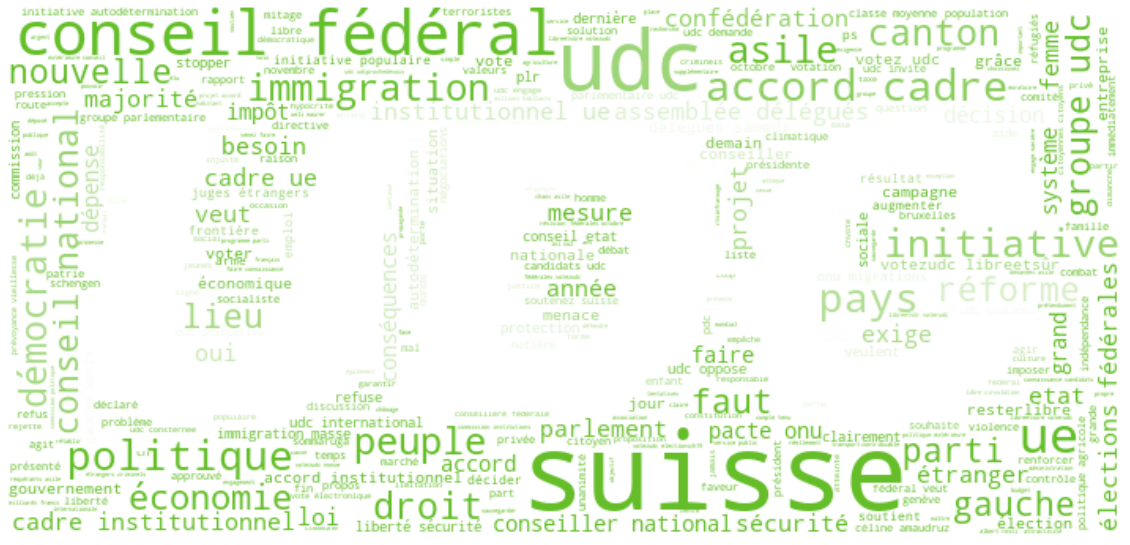

In [84]:
draw_wordcloud("data/logo/UDC_logo.jpg", UDC_text)

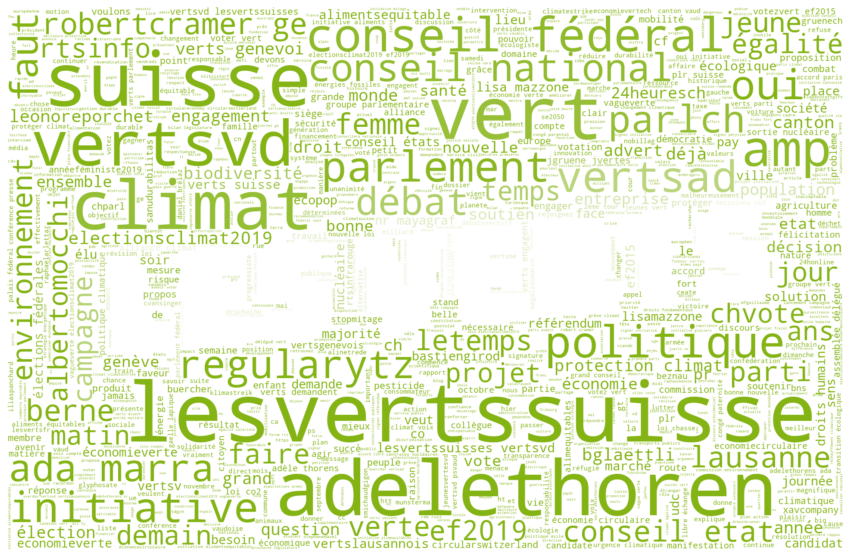

In [85]:
draw_wordcloud("data/logo/VERTS_logo.png", VERTS_text)

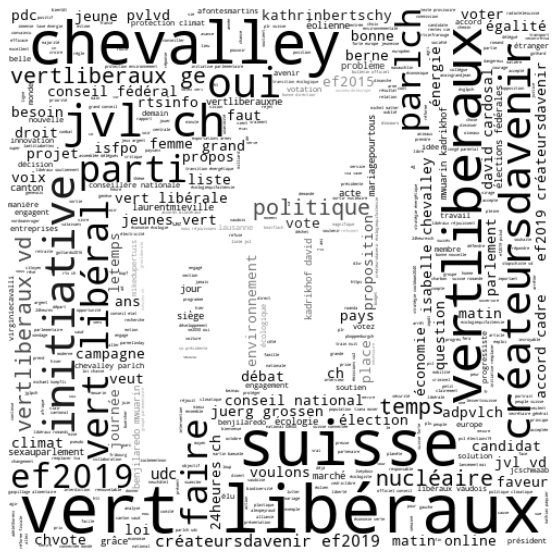

In [86]:
draw_wordcloud("data/logo/VERTS_LIB_logo.png", VERTS_LIB_text)

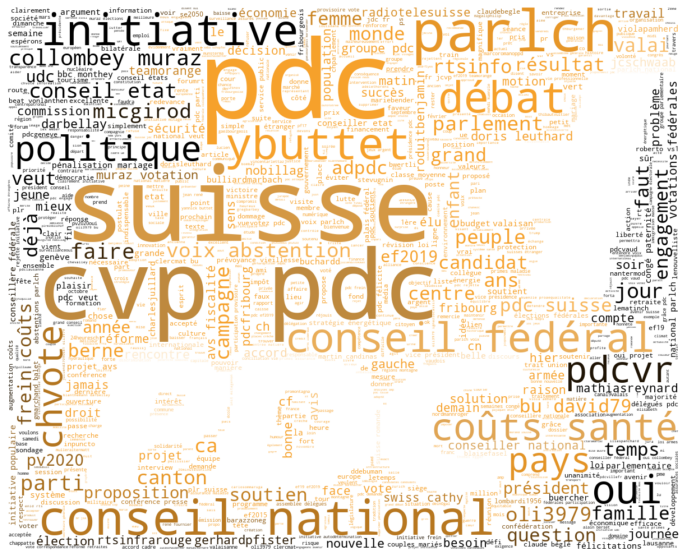

In [39]:
draw_wordcloud("data/logo/PDC_logo.png", PDC_text)

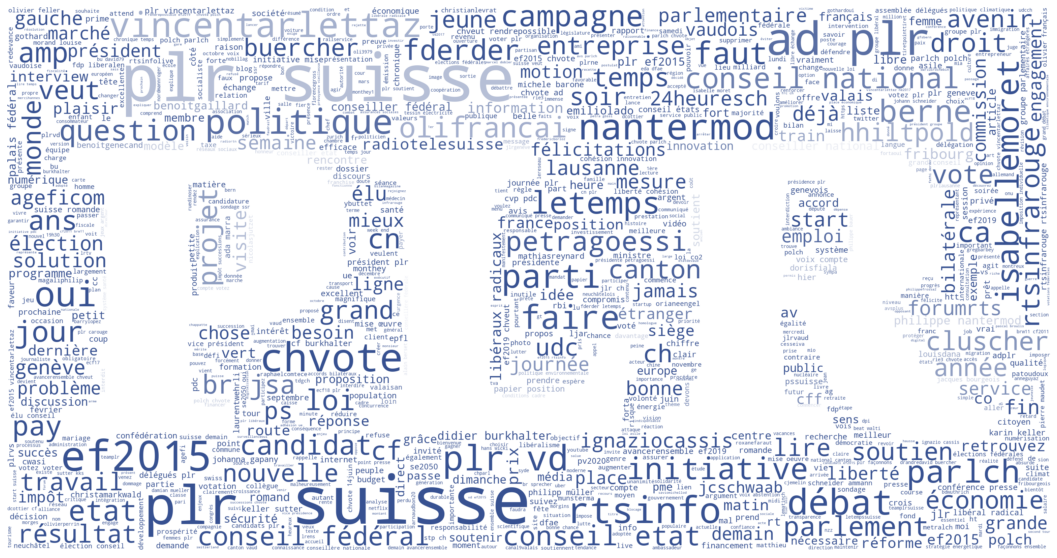

In [87]:
draw_wordcloud("data/logo/PLR_logo.png", PLR_text)

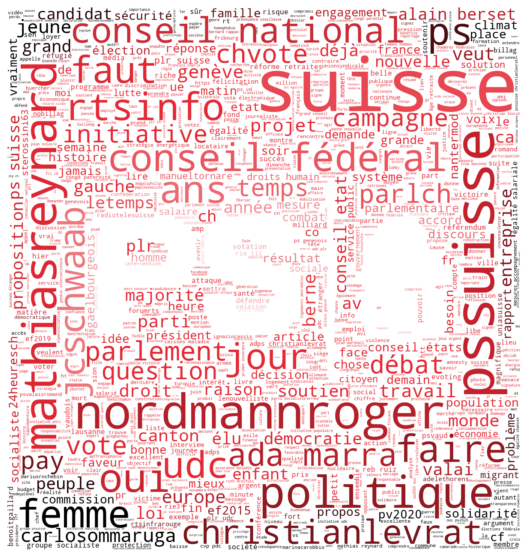

In [41]:
draw_wordcloud("data/logo/PS_logo.png", PS_text)

# Word2Vec


In [42]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [43]:
texts = [VERTS_text.split(" "), UDC_text.split(" "), PLR_text.split(" "), PDC_text.split(" "), VERTS_LIB_text.split(" "), PS_text.split(" ")]

In [44]:
keywords = topics_list_to_keyword(topics_list)

def text_to_list_keyword(text):
    mask = np.isin(text,keywords)
    array = np.array(text[:])
    return array[mask]

In [45]:
UDC_list_keyword = text_to_list_keyword(UDC_text.split(" "))
PS_list_keyword = text_to_list_keyword(PS_text.split(" "))
PLR_list_keyword = text_to_list_keyword(PLR_text.split(" "))
PDC_list_keyword = text_to_list_keyword(PDC_text.split(" "))
VERTS_list_keyword = text_to_list_keyword(VERTS_text.split(" "))
VERTS_LIB_list_keyword = text_to_list_keyword(VERTS_LIB_text.split(" "))

parties_list_keyword = [UDC_list_keyword, PS_list_keyword, PLR_list_keyword, PDC_list_keyword, VERTS_list_keyword, VERTS_LIB_list_keyword]

In [46]:
vector_size = 100
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
model = Doc2Vec(documents, vector_size=vector_size, window=10, min_count=1, workers=4)

In [47]:
def mean_list_word(list_word, model):
    mean = np.zeros(model.vector_size)
    for t in list_word:
        mean += model[t]
    return mean/len(list_word)

In [48]:
mean_UDC = mean_list_word(UDC_list_keyword, model)
mean_PS = mean_list_word(PS_list_keyword, model)
mean_PLR = mean_list_word(PLR_list_keyword, model)
mean_PDC = mean_list_word(PDC_list_keyword, model)
mean_VERTS = mean_list_word(VERTS_list_keyword, model)
mean_VERTS_LIB = mean_list_word(VERTS_LIB_list_keyword, model)

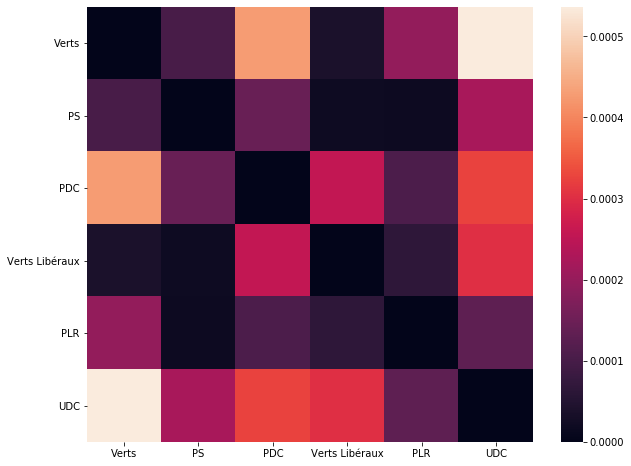

<Figure size 720x720 with 0 Axes>

In [49]:
means_parties = [mean_VERTS, mean_PS, mean_PDC, mean_VERTS_LIB, mean_PLR, mean_UDC]
parties = ["Verts", "PS", "PDC", "Verts Libéraux","PLR", "UDC"]

similiraties = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        similiraties[i][j] = spatial.distance.cosine(means_parties[i], means_parties[j])

fig, ax = plt.pyplot.subplots(figsize=(10,8)) 
sns.heatmap(similiraties, xticklabels=parties, yticklabels=parties, ax=ax)
plt.pyplot.figure(figsize=[10,10])
plt.pyplot.show()

In [50]:
def mean_list_word(list_keyword, model):
    mean = np.zeros(model.vector_size)
    for t in list_keyword:
        mean += model[t]
    return mean/len(list_keyword)

In [51]:
mean2_VERTS = mean_list_word(VERTS_text.split(" "), model)
mean2_UDC = mean_list_word(UDC_text.split(" "), model)
mean2_PS = mean_list_word(PS_text.split(" "), model)
mean2_PLR = mean_list_word(PLR_text.split(" "), model)
mean2_PDC = mean_list_word(PDC_text.split(" "), model)
mean2_VERTS_LIB = mean_list_word(VERTS_LIB_text.split(" "), model)

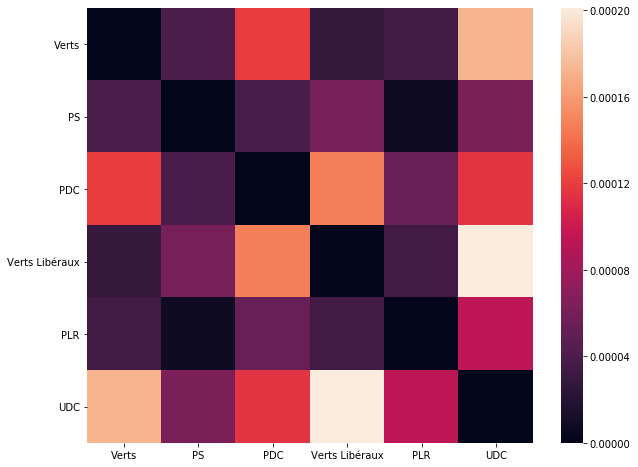

<Figure size 720x720 with 0 Axes>

In [52]:
means2_parties = [mean2_VERTS, mean2_PS, mean2_PDC, mean2_VERTS_LIB, mean2_PLR, mean2_UDC]
parties = ["Verts", "PS", "PDC", "Verts Libéraux","PLR", "UDC"]

similiraties2 = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        similiraties2[i][j] = spatial.distance.cosine(means2_parties[i], means2_parties[j])
        
fig, ax = plt.pyplot.subplots(figsize=(10,8)) 
sns.heatmap(similiraties2, xticklabels=parties, yticklabels=parties, ax=ax)
plt.pyplot.figure(figsize=[10,10])
plt.pyplot.show()

# Use a dictionary

In [53]:
with open('data/frenchwords', 'r',  encoding="utf-8") as file:
    french_words = file.read().replace('\n', '|')

In [69]:
PLR_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='PLR Suisse', dictionary_words= True, dictionary =french_words)

In [63]:
VERTS_dict_text_list = tweets_to_text(tweets, lang='fr', party_name= 'Les VERTS suisses 🌻', dictionary_words= True, dictionary = french_words)

In [64]:
UDC_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='UDC Suisse', dictionary_words= True, dictionary = french_words)

In [65]:
PDC_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='CVP PDC PPD PCD', dictionary_words= True, dictionary = french_words)

In [66]:
PS_dict_text_list = tweets_to_text(tweets, lang='fr', party_name='PS Suisse', dictionary_words= True, dictionary = french_words)

In [76]:
VERTS_LIB_dict_text_list= tweets_to_text(tweets, lang='fr', party_name="Vert'libéraux Suisse", dictionary_words= True, dictionary = french_words)

In [77]:
PLR_dict_text = " ".join(PLR_dict_text_list)

In [71]:
VERTS_dict_text = " ".join(VERTS_dict_text_list)

In [72]:
UDC_dict_text = " ".join(UDC_dict_text_list)

In [73]:
PDC_dict_text = " ".join(PDC_dict_text_list)

In [74]:
PS_dict_text = " ".join(PS_dict_text_list)

In [78]:
VERTS_LIB_dict_text = " ".join(VERTS_LIB_dict_text_list)

In [60]:
PLR_dict_bag = text_to_bag(PLR_dict_text, dictionary_words = True)

In [79]:
VERTS_dict_bag = text_to_bag(VERTS_dict_text, dictionary_words = True)

In [80]:
UDC_dict_bag = text_to_bag(UDC_dict_text, dictionary_words = True)

In [81]:
PDC_dict_bag = text_to_bag(PDC_dict_text, dictionary_words = True)

In [82]:
PS_dict_bag = text_to_bag(PS_dict_text, dictionary_words = True)

In [83]:
VERTS_LIB_dict_bag = text_to_bag(VERTS_LIB_dict_text, dictionary_words = True)

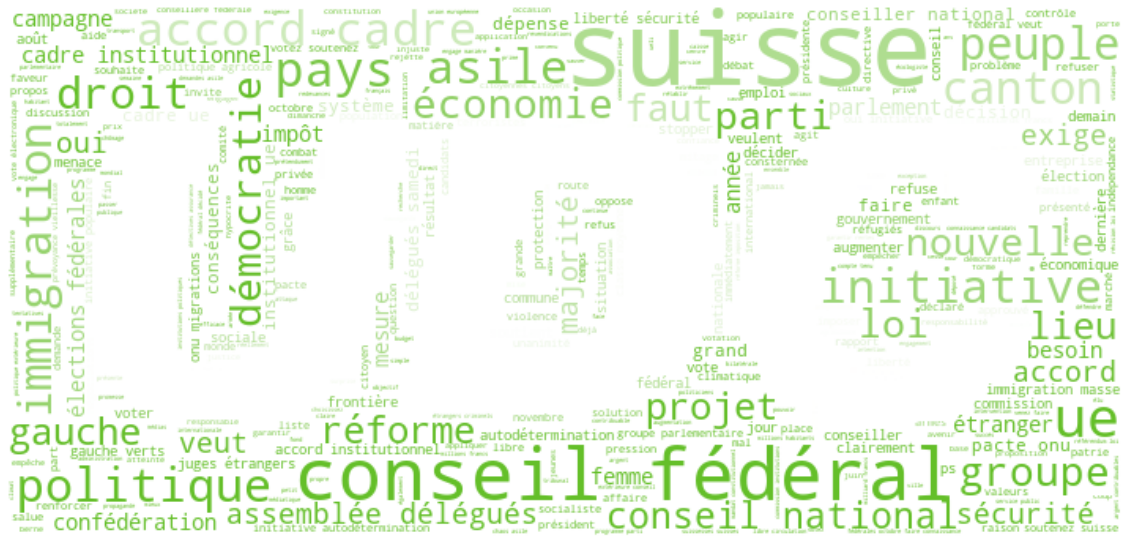

In [88]:
draw_wordcloud("data/logo/UDC_logo.jpg", UDC_dict_text)

In [ ]:
draw_wordcloud("data/logo/VERTS_logo.png", VERTS_dict_text)

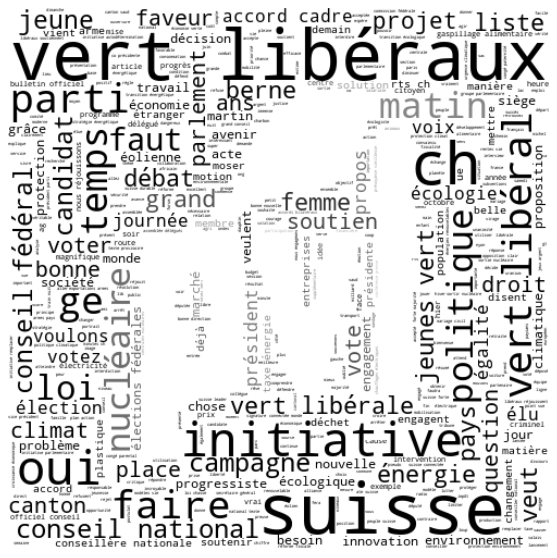

In [92]:
draw_wordcloud("data/logo/VERTS_LIB_logo.png", VERTS_LIB_dict_text)

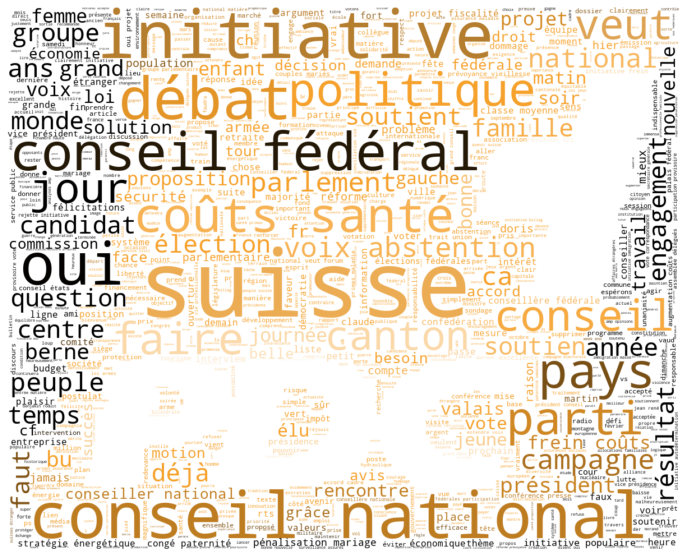

In [93]:
draw_wordcloud("data/logo/PDC_logo.png", PDC_dict_text)

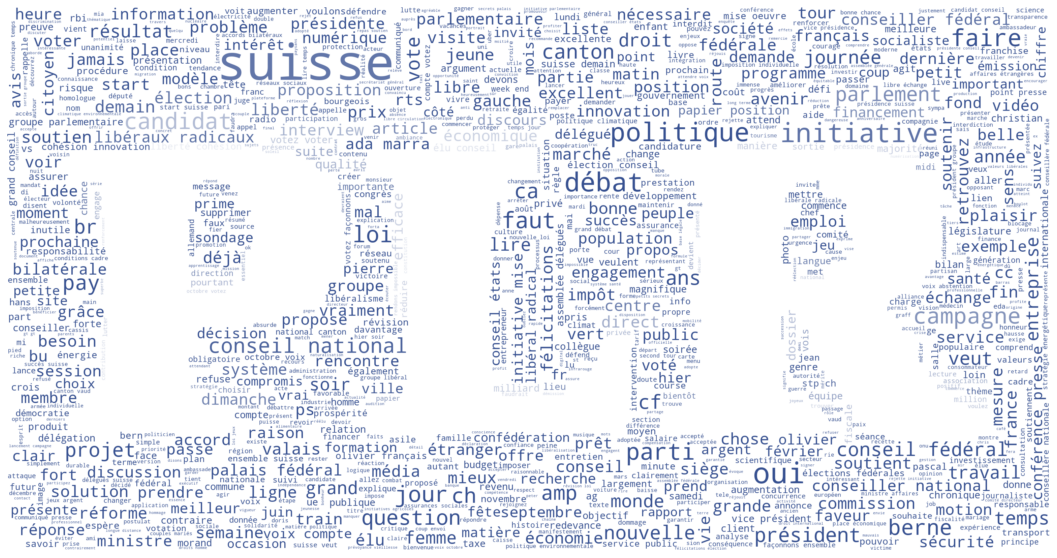

In [94]:
draw_wordcloud("data/logo/PLR_logo.png", PLR_dict_text)

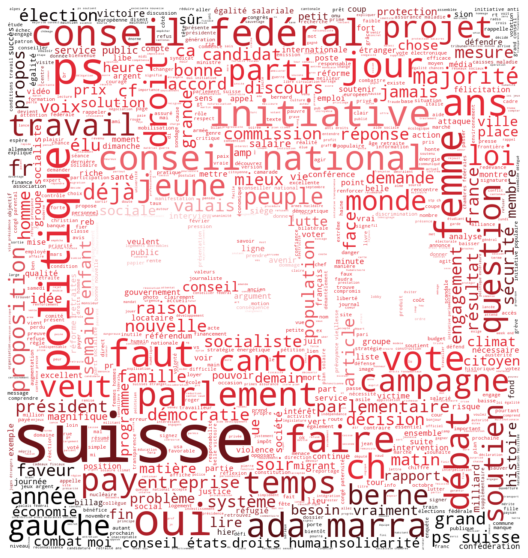

In [96]:
draw_wordcloud("data/logo/PS_logo.png", PS_dict_text)

# Evolution over time

In [175]:
def tweets_to_keywords_frequency_by_year(tweets, party_name, lang='fr'):
    """
    Compute the keywords frequency of the parties by year
    
    party_name: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    """
    keywords_frequency = []
    for year in [[2015],[2016],[2017],[2018],[2019]]:
        keywords_frequency.append(bag_to_kewords_frequency(text_to_bag(tweets_to_text(tweets, lang="fr", party_name=party_name, year=year)), topics_list))
    
    return keywords_frequency

In [176]:
def plot_keywords_frequency_by_year(keywords_frequency):
    """
    Plot the keywords frequency by year
    """
    years = np.arange(2015, 2020)

    fig, ax = plt.pyplot.subplots()

    for topic in topics:
        y = []
        for i in range(0, len(years)):
            y.append(keywords_frequency[i][topic])
        y = np.array(y)
        ax.plot(years, y, label=topic)
    
    ax.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)   
    plt.pyplot.show()

In [177]:
VERTS_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "Les VERTS suisses 🌻")
VERTS_keywords_frequency

[{'Climate': 28.24074074074074,
  'Immigration': 13.88888888888889,
  'Safety': 3.240740740740741,
  'Liberty': 0.9259259259259259,
  'Egality': 8.796296296296296,
  'Economy': 12.5,
  'Work': 8.333333333333334,
  'Women': 1.3888888888888888,
  'Digital': 1.8518518518518519,
  'Family': 8.796296296296296,
  'AVS': 2.314814814814815,
  'Health': 5.092592592592593,
  'Europe': 4.62962962962963},
 {'Climate': 13.432835820895523,
  'Immigration': 16.417910447761194,
  'Safety': 8.955223880597014,
  'Liberty': 4.477611940298507,
  'Egality': 4.477611940298507,
  'Economy': 17.91044776119403,
  'Work': 8.955223880597014,
  'Women': 1.492537313432836,
  'Digital': 1.492537313432836,
  'Family': 8.955223880597014,
  'AVS': 2.985074626865672,
  'Health': 1.492537313432836,
  'Europe': 8.955223880597014},
 {'Climate': 39.0625,
  'Immigration': 7.03125,
  'Safety': 3.125,
  'Liberty': 3.125,
  'Egality': 2.34375,
  'Economy': 9.375,
  'Work': 14.0625,
  'Women': 3.125,
  'Digital': 0.0,
  'Family

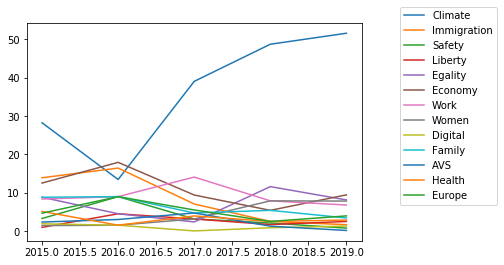

In [178]:
plot_keywords_frequency_by_year(VERTS_keywords_frequency)

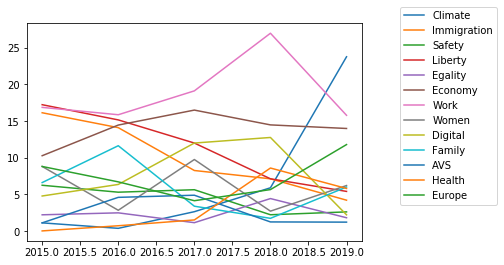

In [179]:
PLR_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "PLR Suisse")
plot_keywords_frequency_by_year(PLR_keywords_frequency)

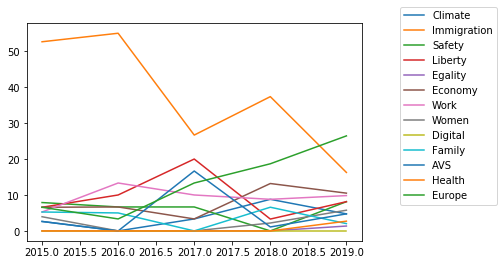

In [180]:
UDC_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "UDC Suisse")
plot_keywords_frequency_by_year(UDC_keywords_frequency)

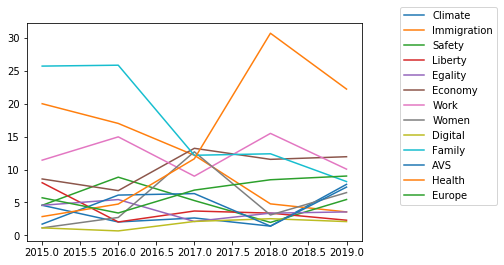

In [181]:
PDC_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "CVP PDC PPD PCD")
plot_keywords_frequency_by_year(PDC_keywords_frequency)

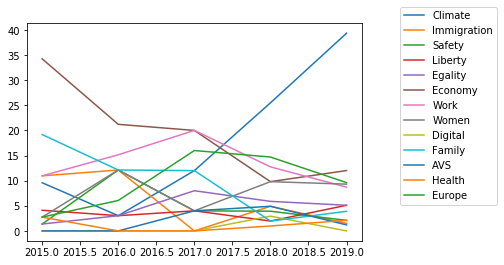

In [182]:
VERTS_LIB_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "Vert'libéraux Suisse")
plot_keywords_frequency_by_year(VERTS_LIB_keywords_frequency)

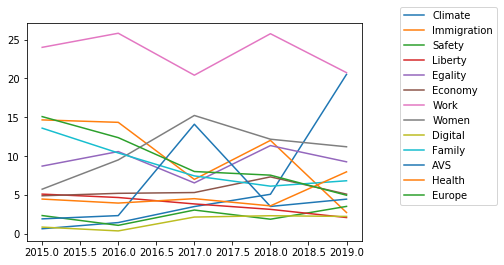

In [183]:
PS_keywords_frequency = tweets_to_keywords_frequency_by_year(tweets, "PS Suisse")
plot_keywords_frequency_by_year(PS_keywords_frequency)